<a href="https://colab.research.google.com/github/maushamkumar/PyTorch/blob/main/02_neural_network_classification_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 02. Neural Networks classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (There can be multiple things as options )

## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n{X[:5]}")
print(f"First 5 samples of y:\n{y[:5]}")

First 5 samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
[1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})

In [6]:
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [7]:
# prompt: Using dataframe circles: scatter plot

import altair as alt
chart = alt.Chart(circles).mark_circle().encode(x='X1', y='X2', color='label')
chart


alt.Chart(...)

In [8]:
# Visualize with plot
import matplotlib.pyplot as plt


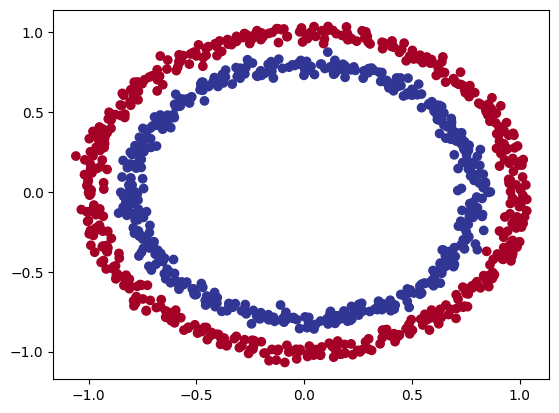

In [9]:
plt.scatter(X[:, 0], X[:, 1], c= y, cmap=plt.cm.RdYlBu)

**Note:** The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [10]:
X.shape, y.shape

((1000, 2), (1000,))

In [11]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [12]:
# View the first example of features and label
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")


Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [13]:
import torch
torch.__version__

'2.2.1+cu121'

In [14]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [15]:
X.dtype

dtype('float64')

In [16]:
type(X)

numpy.ndarray

In [17]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [18]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [19]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [20]:
# Split data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, # 0.2 means 20% of the data will be used for testing and 80% for training
                                                    random_state=42)

In [21]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agonistic code so our code will run on an accelerator (GPU) if there is one
2. Construct our model (by subclassing `nn.Module` )
3. Define our loss function and optimizer
4. Create a training and test loop

In [22]:
# Import PyTorch and nn
import torch
from torch import nn

In [23]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [24]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module`. (almost all model in PyTorch subclass `nn.Module`)
2. create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (for forward computation) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [25]:
X_train.shape

torch.Size([800, 2])

In [26]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [27]:
# 1. Construct a model that subclasses nn.Module
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layer capable of handling the shape of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # Take in 2 features and upscale to 5 features. # This module supports TensorFloat32.
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # in_features match with out_features of previous layer  # Takse in  5 features from the previous layer and outputs a single feature (same shape as y). #  )


  # 3. Define a forward() method on that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModel().to(device)
model_0

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [28]:
device

'cpu'

In [29]:
# 1. Construct a model that subclasses nn.Module
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layer capable of handling the shape of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # Take in 2 features and upscale to 5 features. # This module supports TensorFloat32.
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # in_features match with out_features of previous layer  # Takse in  5 features from the previous layer and outputs a single feature (same shape as y). #  )

    self.two_linear_layers = nn.Sequential(nn.Linear(in_features=2, out_features=5),
                                          nn.Linear(in_features=5, out_features=1))
  # 3. Define a forward() method on that outlines the forward pass
  def forward(self, x):
    # return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2
    return self.two_linear_layers(x)

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModel().to(device)
model_0

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [30]:
next(model_0.parameters()).device

device(type='cpu')

In [31]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [32]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0290,  0.0331],
                      [ 0.3724,  0.3186],
                      [-0.0653,  0.4026],
                      [ 0.4125, -0.6931],
                      [-0.2926,  0.1606]])),
             ('0.bias', tensor([ 0.5782,  0.6469, -0.0949,  0.6591, -0.2572])),
             ('1.weight',
              tensor([[-0.2575, -0.0969,  0.1470, -0.3861, -0.2129]])),
             ('1.bias', tensor([0.1971]))])

In [33]:
# Make Prediction
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, shape: {X_test.shape}")
print(f"\n First 10 predictions: {untrained_preds[:10]}")
print(f"\n First 10 label: \n{y_test[:10]}")

Length of predictions: 200, shape: torch.Size([200, 1])
Length of test samples: 200, shape: torch.Size([200, 2])

 First 10 predictions: tensor([[ 0.0010],
        [ 0.0126],
        [-0.2023],
        [ 0.0593],
        [-0.4768],
        [-0.4676],
        [-0.2174],
        [-0.3306],
        [-0.1904],
        [ 0.0103]])

 First 10 label: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [34]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [35]:
X_test[:10]

tensor([[-0.3752,  0.6827],
        [ 0.0154,  0.9600],
        [-0.7028, -0.3147],
        [-0.2853,  0.9664],
        [ 0.4024, -0.7438],
        [ 0.6323, -0.5711],
        [ 0.8561,  0.5499],
        [ 1.0034,  0.1903],
        [-0.7489, -0.2951],
        [ 0.0538,  0.9739]])

###  2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.


For example, for regression, you might want MAE or MSE.

For classification, you might want to cross entropy or softmax.

As a reminder, the loss function measures how wrong your model's predictions are.

And for optimizers, two of the most common are Adam and SGD, however PyTorch has many built-in options.

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, check out this article: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

* For a definition on what a logit is in deep learning

* For different optimizers: `torch.optim`


In [36]:
# Setup the loss function
# loss = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss

# nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# ) # We'll get the same result by using nn.BCEWithLogitsLoss()
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = BCELoss + Sigmoid activation function bulit-in

# Setup an optimizer
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [37]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0290,  0.0331],
                      [ 0.3724,  0.3186],
                      [-0.0653,  0.4026],
                      [ 0.4125, -0.6931],
                      [-0.2926,  0.1606]])),
             ('0.bias', tensor([ 0.5782,  0.6469, -0.0949,  0.6591, -0.2572])),
             ('1.weight',
              tensor([[-0.2575, -0.0969,  0.1470, -0.3861, -0.2129]])),
             ('1.bias', tensor([0.1971]))])

In [38]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred))* 100
  return acc

In [39]:
y_true = (torch.tensor([[1, 2], [3, 4]]))
y_pred = (torch.tensor([[1, 2], [3, 4]]))
correct = torch.eq(y_true, y_pred).sum().item()

In [40]:
correct

4

## Train model

To train our model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate loss
3. Optimizer zero grad
4. Loss Backward pass
5. Optimizer(gradient descent)


### 3.1 Going from raw logits -> prediction probabilities -> prediction labels
our model outputs are going to be raw  **logits**.

We can convert **logits** into prediction **probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary cross-entropy and softmax for multiclass classification).

Then we can convert our our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [41]:
# View the first 5 output of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0010],
        [ 0.0126],
        [-0.2023],
        [ 0.0593],
        [-0.4768]])

In [43]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0290,  0.0331],
                      [ 0.3724,  0.3186],
                      [-0.0653,  0.4026],
                      [ 0.4125, -0.6931],
                      [-0.2926,  0.1606]])),
             ('0.bias', tensor([ 0.5782,  0.6469, -0.0949,  0.6591, -0.2572])),
             ('1.weight',
              tensor([[-0.2575, -0.0969,  0.1470, -0.3861, -0.2129]])),
             ('1.bias', tensor([0.1971]))])

In [44]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [45]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5003],
        [0.5031],
        [0.4496],
        [0.5148],
        [0.3830]])

For our prediction probability values, we need to perform a range-style rounding on them:

* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [ ]:
torch.round(y_pred_probs)

In [47]:
# Find the predicted labels
Y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(Y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
Y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 0., 1., 0.])

## 3.2 Building a training and testing loop


In [48]:
device

'cpu'

In [ ]:
!nvidia-smi # If we have a GPU, check that it's on

In [54]:
torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 100

# put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


# Building training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> pred probs -> pred labels

  # 2. Calculate loss and accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
                #  y_train)

  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward(backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss and accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                            y_pred = test_pred)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70222, Accuracy: 44.62% | Test loss: 0.70469, Test acc: 41.00%
Epoch: 10 | Loss: 0.69651, Accuracy: 47.88% | Test loss: 0.69991, Test acc: 48.50%
Epoch: 20 | Loss: 0.69482, Accuracy: 49.50% | Test loss: 0.69836, Test acc: 51.00%
Epoch: 30 | Loss: 0.69422, Accuracy: 50.25% | Test loss: 0.69766, Test acc: 49.00%
Epoch: 40 | Loss: 0.69393, Accuracy: 50.50% | Test loss: 0.69721, Test acc: 48.50%
Epoch: 50 | Loss: 0.69375, Accuracy: 50.75% | Test loss: 0.69686, Test acc: 47.50%
Epoch: 60 | Loss: 0.69362, Accuracy: 50.50% | Test loss: 0.69656, Test acc: 48.00%
Epoch: 70 | Loss: 0.69352, Accuracy: 50.62% | Test loss: 0.69630, Test acc: 48.50%
Epoch: 80 | Loss: 0.69343, Accuracy: 50.75% | Test loss: 0.69607, Test acc: 49.00%
Epoch: 90 | Loss: 0.69336, Accuracy: 51.00% | Test loss: 0.69587, Test acc: 48.50%


In [50]:
torch.cuda.manual_seed(42)

In [51]:
loss_fn

BCEWithLogitsLoss()

In [52]:
loss_fn_without_logits = nn.BCELoss()
loss_fn_without_logits # This loss except for prediction probabilities as input

BCELoss()

## 4. Make prediction and evaluate the model

From the metrics it looks like our model isn't learning anything.

So to inspect it let's make some predictions and make them visual!

To do so, we're going to import a function called `plot_decision_boundary()`

In [56]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

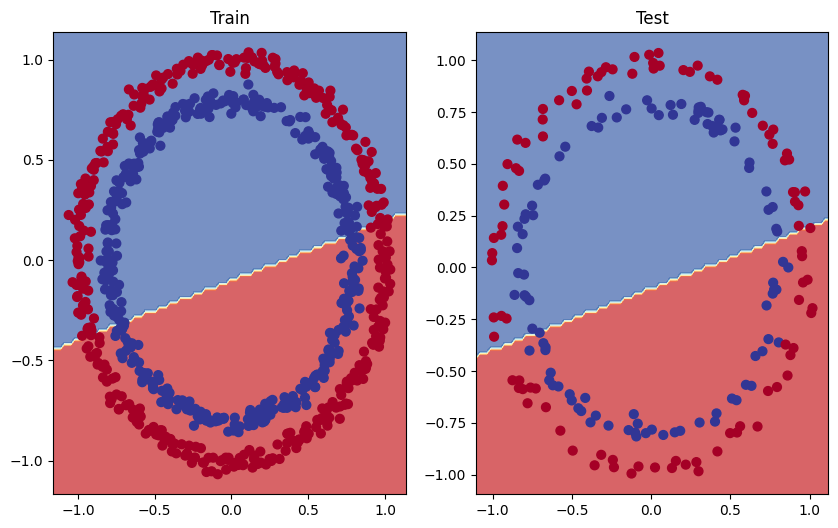

In [57]:
# Plot decision boundary of the model
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(122)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data

* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer - go from 200 epochs to 500 epochs
* Changing the activation functions
* Change the learning rate
* change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred to **hyperparameters**.

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [59]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # This way of writing operations leverages speed-ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [61]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0081,  0.0580],
                      [ 0.3668,  0.3253],
                      [-0.0545,  0.3897],
                      [ 0.3855, -0.6607],
                      [-0.3158,  0.1882]])),
             ('0.bias', tensor([ 0.5635,  0.6421, -0.0862,  0.6369, -0.2708])),
             ('1.weight',
              tensor([[-0.2258, -0.0587,  0.0922, -0.2349, -0.2763]])),
             ('1.bias', tensor([0.2585]))])

In [62]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

We have more hidden layers in model_1 than in model_0. In model_1, we have 3 hidden layers, and in model_0 we have 2 hidden layers.

In [60]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)


In [63]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
  # Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # 2. Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

# 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step(Gradient Descent)
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Caculate loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test Loss: 0.69261, Test Accuracy: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test Loss: 0.69379, Test Accuracy: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test Loss: 0.69437, Test Accuracy: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test Loss: 0.69458, Test Accuracy: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test Loss: 0.69465, Test Accuracy: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69467, Test Accuracy: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%


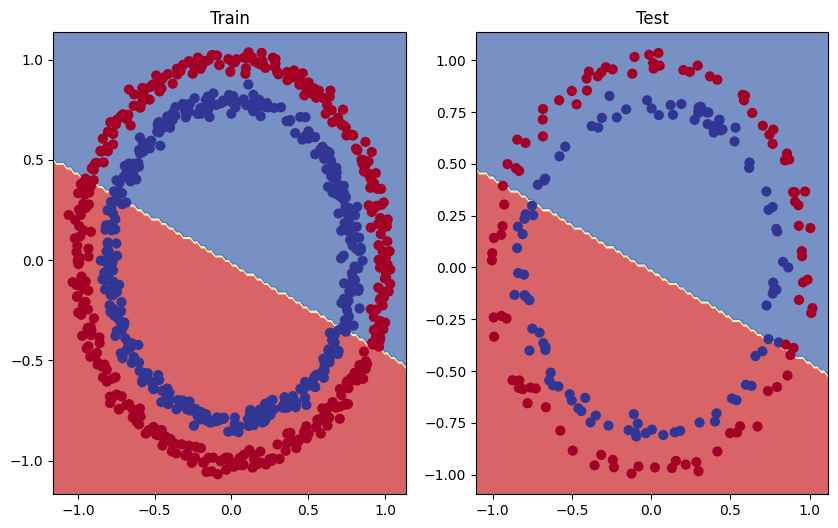

In [65]:
# Plot the decision boundaries
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(122)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [70]:
# Create some data (same as in notebook 01)
weights = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = X_regression * weights + bias

# Check the data
print(len(X_regression), len(y_regression))
X_regression[:5], y_regression[:5]

100 100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [71]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

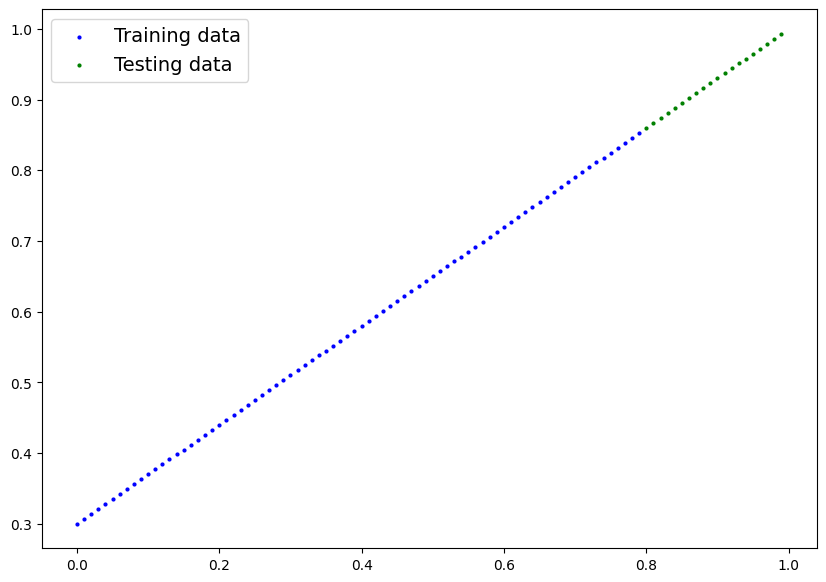

In [72]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [74]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [75]:
X_train_regression[:5], y_train_regression[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

### 5.3 Adjusting  `model_1` to fit a straight line

In [76]:
# Same architecture as model_1(but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2


Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(X))) # This way of writing operations leverages speed-ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

In [77]:
# Loss and Optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [ ]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):

  # 1. Forward pass
  y_pred = model_2(X_train_regression)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train_regression)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_pred = model_2(X_test_regression)

    # 2. Caculate loss
    test_loss = loss_fn(test_pred, y_test_regression)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")